In [1]:
!pip install git+https://github.com/kornia/kornia@align_corners=False
!pip install pytorch_metric_learning

  Cloning https://github.com/kornia/kornia (to revision align_corners=False) to /tmp/pip-req-build-j_qmu_z2
  Running command git clone -q https://github.com/kornia/kornia /tmp/pip-req-build-j_qmu_z2
  Running command git checkout -b align_corners=False --track origin/align_corners=False
  Switched to a new branch 'align_corners=False'
  Branch align_corners=False set up to track remote branch align_corners=False from origin.
  Created wheel for kornia: filename=kornia-0.2.0+cabdd68-py2.py3-none-any.whl size=147068 sha256=190b5f08030b238e330fee0c433b98af2ee08c1deabc61e8703fc2d8e4f785fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-jw6uz2h_/wheels/08/7e/79/0985a0e702fa8496fd528e669e2ee369290c998348c7474147
Successfully built kornia


In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import random
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar
from fastai2.basics import *
from fastcore import *
from fastai2.vision.all import *
from fastai2.callback.all import *
from fastprogress import fastprogress
from fastai2.callback.mixup import *
from fastscript import *
import torchvision as tv
import kornia as K

def imshow_torch(tensor, *kwargs):
    plt.figure()
    plt.imshow(K.tensor_to_image(tensor), *kwargs)
    return

In [2]:
train_ds_name = 'liberty'
val_ds_name = 'notredame'
ds_root = '/home/old-ufo/storage/datasets/UBC-Phototour-Patches-Torch'

First, we will define modified dataset to match HardNet implementation.
Specifically, it generates pairs of the same-class images for the batch.

In [3]:
class PairPhotoTour(tv.datasets.PhotoTour):
    """
    From the PhotoTour Dataset it generates pairs of same class in a batch
    Based on code from https://github.com/vbalnt/tfeat
    """
    def __init__(self,
                 train_mode=True, # We need different behavoir for train and test mode
                 bs = 1024, #batch size. There will be only 2 samples of same class in the batch.
                 n_pairs = 1024*5000, #It is simple to have n_pairs to be divisible by bs
                 *arg, **kw):
        super(PairPhotoTour, self).__init__(*arg, **kw)
        self.train_mode = train_mode
        self.n_pairs = n_pairs
        self.bs = bs
        # Dict: indexes of the class samples by class label
        self.indices_dict = self.create_indices(self.labels.numpy())
        if self.train_mode:
            self.generate_pairs()
        return
    
    def create_indices(self, labels):
        inds = dict()
        for idx, ind in enumerate(labels):
            if ind not in inds:
                inds[ind] = []
            inds[ind].append(idx)
        return inds

    def generate_pairs(self):
        labels = self.labels
        num_pairs = self.n_pairs
        self.pairs = []
        indices_dict = self.indices_dict
        classes = np.unique(self.labels.numpy())
        n_classes = classes.shape[0]
        num_epochs = num_pairs // n_classes + 1
        print('Generating {} pairs for training'.format(self.n_pairs))
        for ep in progress_bar(range(num_epochs)):
            classes_perm = np.random.permutation(classes)
            for c in classes_perm:
                samples_in_class = indices_dict[c]
                if len(samples_in_class) > 2:
                    random.shuffle(samples_in_class)
                self.pairs.append([*samples_in_class[:2], c])
        self.pairs = torch.LongTensor(self.pairs)[:num_pairs]
        return 

    def __getitem__(self, index):
        if not self.train_mode:
            m = self.matches[index]
            img1 = self.data[m[0]]
            img2 = self.data[m[1]]
            # Output: two concatenated  an match/non-match label, as definited in Brown at.al 2010
            return img1.unsqueeze(0), img2.unsqueeze(0), m[2] 
        t = self.pairs[index]
        img_a, img_p, label = self.data[t[0]], self.data[t[1]], t[2]
        # Output: two concatenated images of the same class and class label
        return img_a.unsqueeze(0), img_p.unsqueeze(0), label

    def __len__(self):
        if self.train_mode:
            return self.pairs.size(0)
        else:
            return self.matches.size(0)

We will do augmentation on GPU with [kornia](https://github.com/kornia/kornia)

In [4]:
orig_size = 64
out_size = 32
sigma = orig_size / (2.*out_size)

train_aug = nn.Sequential( 
    K.filters.GaussianBlur2d((7,7),(0.6,  0.6)), # Blur for proper downscale
    torch.nn.ReplicationPad2d(8), # otherwise small black corners appear
    K.augmentation.RandomAffine(degrees=(-5.0, 5.0),
                                scale=(0.9, 1.0),
                                shear=(5.0, 5.0),
                                translate=(0.03, 0.03)),
    K.augmentation.CenterCrop(orig_size),
    K.Resize((out_size,out_size)))

test_aug = nn.Sequential( 
    K.filters.GaussianBlur2d((7,7),(0.6,  0.6)), # Blur for proper downscale
    K.Resize((out_size,out_size)))


In [5]:
from fastai2  import *
# We need to transform all images
class TupleAug(ItemTransform):
    def __init__(self, tfm):
        self.tfm = tfm
    def encodes(self, o): 
        out = []
        with torch.no_grad():
            for i,oi in enumerate(o):
                if i < len(o) - 1:
                    out.append(self.tfm(oi.float()))
                else:
                    out.append(oi)
        return out
class ReshapeTupleToBatch(ItemTransform):
    def encodes(self, o): 
        return torch.cat(o[:-1],dim=0), o[-1].repeat(len(o)-1)    

In [6]:
class BatchRandomFlip(ItemTransform):
    def encodes(self, o): 
        mask = torch.randint_like(o[-1], 0,2) > 0
        out = [] 
        with torch.no_grad():
            for oi in o[:-1]:
                out.append(oi)
                out[-1].masked_scatter_(mask.view(-1,1,1,1), oi.flip(3))
            mask2 = torch.randint_like(o[-1], 0,2) > 0
            for i, oi in enumerate(out):
                out[i].masked_scatter_(mask2.view(-1,1,1,1), oi[mask2].flip(3))
        out.append(o[-1])
        return out

Lets create data loaders

Generating 5120000 pairs for training


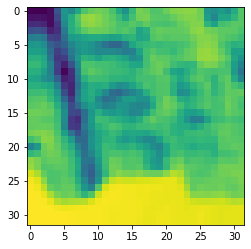

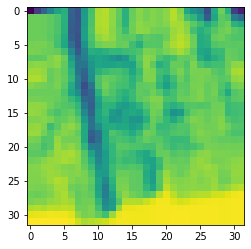

In [7]:
BS = 1024
TEST_BS = 128
N_WORKERS = 4

ds_train = PairPhotoTour(root=ds_root,
                              name=train_ds_name,
                              bs=BS,
                              n_pairs=5000*BS,  
                              train_mode=True)

ds_val = PairPhotoTour(root=ds_root,
                      name=val_ds_name,
                      train_mode=False)

dl_train = TfmdDL(ds_train,
                 device=torch.device('cuda:0'),
                 after_item=[ToTensor], 
                 after_batch=[TupleAug(train_aug), # augmening both patches in pair
                              BatchRandomFlip,  # random flip
                              ReshapeTupleToBatch], #two patches -> single tensor
                 bs=BS, num_workers=N_WORKERS)

dl_val = TfmdDL(ds_val,
                 device=torch.device('cuda:0'),
                 after_item=[ToTensor], 
                 after_batch=[TupleAug(test_aug), ReshapeTupleToBatch],
                 bs=TEST_BS, num_workers=N_WORKERS)

patches, labels  = dl_train.one_batch()

imshow_torch(patches[0])
imshow_torch(patches[0+BS])


Now define HardNet model
(https://arxiv.org/pdf/1705.10872.pdf)

![image.png](training-hardnet-in-fastai2-with-kornia-aug_files/att_00000.png)


In [8]:
#monkey patch (on my PC torch.qr outputs nans)
def orthogonal_(tensor, gain=1):
    r"""Fills the input `Tensor` with a (semi) orthogonal matrix, as
    described in `Exact solutions to the nonlinear dynamics of learning in deep
    linear neural networks` - Saxe, A. et al. (2013). The input tensor must have
    at least 2 dimensions, and for tensors with more than 2 dimensions the
    trailing dimensions are flattened.

    Args:
        tensor: an n-dimensional `torch.Tensor`, where :math:`n \geq 2`
        gain: optional scaling factor

    Examples:
        >>> w = torch.empty(3, 5)
        >>> nn.init.orthogonal_(w)
    """
    if tensor.ndimension() < 2:
        raise ValueError("Only tensors with 2 or more dimensions are supported")

    rows = tensor.size(0)
    cols = tensor.numel() // rows
    flattened = tensor.new(rows, cols).normal_(0, 1)

    if rows < cols:
        flattened.t_()

    # Compute the qr factorization
    # Here is patch: use np.linalg.qr instead of torch.qr
    q, r = np.linalg.qr(flattened)
    r = torch.from_numpy(r)
    q = torch.from_numpy(q)
    # Make Q uniform according to https://arxiv.org/pdf/math-ph/0609050.pdf
    d = torch.diag(r, 0)
    ph = d.sign()
    q *= ph

    if rows < cols:
        q.t_()

    with torch.no_grad():
        tensor.view_as(q).copy_(q)
        tensor.mul_(gain)
    return tensor
torch.nn.init.orthogonal_ = orthogonal_

In [9]:
class HardNet(nn.Module):
    """HardNet model definition
    """
    def __init__(self):
        super(HardNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias = False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2,padding=1, bias = False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(128, 128, kernel_size=8, bias = False),
            nn.BatchNorm2d(128, affine=False),
            Flatten()
        )
        self.features.apply(self.weights_init)
        return
    def input_norm(self, x):
        std, mean = torch.std_mean(x, dim=(2,3), keepdim=True)
        return (x - mean) / (std + 1e-7)
    def weights_init(self, m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.orthogonal_(m.weight.data, gain=0.6)
            print (m.weight.sum())
            try:
                nn.init.constant_(m.bias.data, 0.01)
            except: pass
        return
    def forward(self, input):
        x = self.features(self.input_norm(input))
        return F.normalize(x, p=2, dim=1)

Loss function: triplet margin loss with hard-in-batch mining.

![image.png](training-hardnet-in-fastai2-with-kornia-aug_files/att_00001.png)

We will use great repo by Kevin Musgrave.

https://github.com/KevinMusgrave/pytorch-metric-learning

In [10]:
# Loss function
from pytorch_metric_learning import losses, miners

LossFn = losses.TripletMarginLoss(margin = 1.0)
Miner = miners.BatchHardMiner()

def loss_hard_triplet_margin(x, y):
    hard_pairs = Miner(x, y)
    loss = LossFn(x, y, hard_pairs)
    return loss

Validation metric - False positive rate at recall = 95%

In [11]:
#Original FPR95
def ErrorRateAt95Recall(distances, labels):
    '''From https://github.com/DagnyT/hardnet/blob/master/code/EvalMetrics.py'''
    recall_point = 0.95
    labels = labels[np.argsort(distances)]
    # Sliding threshold: get first index where recall >= recall_point. 
    # This is the index where the number of elements with label==1 below the threshold reaches a fraction of 
    # 'recall_point' of the total number of elements with label==1. 
    # (np.argmax returns the first occurrence of a '1' in a bool array). 
    threshold_index = np.argmax(np.cumsum(labels) >= recall_point * np.sum(labels)) 
    FP = np.sum(labels[:threshold_index] == 0) # Below threshold (i.e., labelled positive), but should be negative
    TN = np.sum(labels[threshold_index:] == 0) # Above threshold (i.e., labelled negative), and should be negative
    return float(FP) / float(FP + TN)


class FPR95(Metric):
    "Average the values of `func` taking into account potential different batch sizes"
    def reset(self):           self.dists, self.labels = [], []
    def accumulate(self, learn):
        x = learn.pred
        N = x.size(0)
        assert N % 2 == 0
        N_2 = N // 2
        targ = learn.yb[0][:N_2]
        with torch.no_grad():
            dist = torch.norm(x[:N_2]-x[N_2:],p=2,dim=1)
        self.dists.append(dist.cpu().detach().view(-1))
        self.labels.append(targ.cpu().detach().view(-1))
        return
    @property
    def value(self):
        if len(self.dists) == 0: return
        if len(self.labels) == 0: return
        dists = torch.cat(self.dists, dim=0)
        labels = torch.cat(self.labels, dim=0)
        return ErrorRateAt95Recall(dists.detach().cpu().view(-1).numpy(), labels.detach().cpu().view(-1).numpy())

Original implementation regenerates random pairs before each epoch

In [12]:
class RegeneratePairs(Callback):
    def begin_train(self):
        if learn.training and learn.epoch > 0:
            learn.dls.train_ds.generate_pairs()

Original paper uses SGD with momentum and dampening. We will give a shot with Adam

In [13]:
data = DataLoaders(dl_train, dl_val).cuda()
model = HardNet()
learn = Learner(data, model,
                loss_func=loss_hard_triplet_margin,
                metrics=[FPR95()], cbs=[RegeneratePairs()],
                wd=1e-4)

tensor(-1.6598, grad_fn=<SumBackward0>)
tensor(-4.2974, grad_fn=<SumBackward0>)
tensor(2.2643, grad_fn=<SumBackward0>)
tensor(-0.4888, grad_fn=<SumBackward0>)
tensor(-8.6757, grad_fn=<SumBackward0>)
tensor(-1.3346, grad_fn=<SumBackward0>)
tensor(0.2649, grad_fn=<SumBackward0>)


In [14]:
learn.fit_one_cycle(10, 10.0)

epoch,train_loss,valid_loss,fpr95,time
0,0.931707,1.531047,0.011140,23:47
1,0.927906,1.527577,0.011140,23:41
2,0.928431,1.518422,0.011200,23:25
3,0.925210,1.534905,0.014100,23:17
4,0.920034,1.519193,0.009000,23:33
5,0.914542,1.520321,0.010640,23:13
6,0.908269,1.513802,0.009660,23:16
7,0.895341,1.503396,0.005860,23:14
8,0.884706,1.500254,0.006120,23:15
9,0.878264,1.496547,0.005600,23:14


Generating 5120000 pairs for training


Generating 5120000 pairs for training


Generating 5120000 pairs for training


Generating 5120000 pairs for training


Generating 5120000 pairs for training


Generating 5120000 pairs for training


Generating 5120000 pairs for training


Generating 5120000 pairs for training


Generating 5120000 pairs for training


That's all. Now we can save our model

In [15]:
learn.save('HardNetLib_fastai2KorniaAug')